# Initializing the Problem

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat

# Defining the age and patient groups
age_group = ['[0,25)', '[25,45)', '[45,65)', '[65,75)', '[75,85)', '85+']
patient_group = ['Susceptibles', 'Infected', 'Recovered', 'Deceased']

# Simulation parameters
sim_time = 140 + 1 # in days
vac_start = 60 # vaccination start day
u_max = 55_191 # maximum daily vaccination capacity
u_min = 0      # minimum daily vaccination capacity
n_states = len(patient_group) # S-I-R-D

# Loading contact and population
path = "./Data/contact.csv"
C = pd.read_csv(path, header=None).values
N = np.array([1_058_304, 915_796, 983_789, 384_803, 203_035, 99_516]) # population/group
N_list, n_age = N.tolist(), len(N)

# Loading the model parameters
lbd = np.array([0.0769924521, 0.0290873349, 0.0136872530, 0.1149749309, 0.2326289564, 0.3331837058])
gamma = np.array([0.9216927886, 0.7230105996, 0.5707245171, 0.8482912034, 0.8200428486, 0.6612236351])
delta = np.array([0.0004407167, 0.0018303543, 0.0232746601, 0.0397484004 ,0.1006921381, 0.1514435560])
model_param = np.vstack([lbd, gamma, delta])

# Defining the model
def SIRD(age_group, x_init, Ij, uk):
    Sk, Ik, Rk, Dk = x_init
    lbdk, gammak, deltak = model_param[:, age_group]
    Ckj = C[age_group]

    Sk_plus = Sk - lbdk*Sk*(Ckj @ Ij) - uk
    Ik_plus = Ik + lbdk*Sk*(Ckj @ Ij) - (gammak + deltak)*Ik
    Rk_plus = Rk + gammak*Ik + uk
    Dk_plus = Dk + deltak*Ik

    states_k = [Sk_plus, Ik_plus, Rk_plus, Dk_plus]

    return states_k

# Defining the model simulation function
def sim_model(nb_age_groups, x_init, u):
    Sk_plus, Ik_plus, Rk_plus, Dk_plus = [], [], [], []
    for age_group in range(nb_age_groups):
        states = SIRD(age_group, x_init[:, age_group], x_init[1], u[age_group])
        Sk_plus.append(states[0])
        Ik_plus.append(states[1])
        Rk_plus.append(states[2])
        Dk_plus.append(states[3])
    states = np.hstack([Sk_plus, Ik_plus, Rk_plus, Dk_plus])
    return states

# Initial conditions
I0 = np.array([4.6595088243, 4.3296088874, 4.8417769521, 0.1709101349, 1.4936938584, 1.6144863665])
S0 =  N - I0
R0 = np.zeros(n_age)
D0 = np.zeros(n_age)


# National vaccination strategy

In [4]:
# Defining the national vaccination strategy
def nat_str(n_age, S, u_max):
    u = np.zeros(n_age)
    uk = u_max
    for k in range(n_age-1, -1, -1):
        if S[k] > 0:
            u[k] = min(S[k], uk)
            uk -= u[k]
    return u.astype(int)

# Running the national vaccination strategy
x_nat = np.zeros((n_age*n_states, sim_time))
x_nat[:, 0] = np.hstack([S0, I0, R0, D0])
u_nat = np.zeros((n_age, sim_time))

for n in range(sim_time-1):
    x_init = x_nat[:, n].reshape(n_states, n_age)
    S_init, I_init = x_init[0], x_init[1]
    if n >= vac_start and not (I_init < 1).all():
        u_nat[:, n] = nat_str(n_age, S_init, u_max)
    else:
        u_nat[:, n] = 0

    x_nat[:, n+1] = sim_model(n_age, x_init, u_nat[:, n])

# Reshaping the state vector
x_nat = x_nat.reshape((n_states, n_age, sim_time))

# Computing the disease eradication time
for t in range(sim_time):
    I_init = x_nat[1, :, t]
    if t >= vac_start and (I_init < 1).all():
        erad_nat = t
        break

# Extracting input/states data
S_nat, I_nat, R_nat, D_nat = x_nat
nb_infected = I_nat[:, vac_start:].sum()
nb_deceasd = (D_nat[:, -1] - D_nat[:, vac_start]).sum()
erad_days = erad_nat - vac_start
vax_cons = u_nat.sum()

# Summary
print(f"Number of infected: {nb_infected:.0f} individuals.")
print(f"Number of deceased: {nb_deceasd:.0f} individuals.")
print(f"disease eradiction occurs in {erad_days} days.")
print(f"total vaccines consumed: {vax_cons:.0f} vaccines.")

Number of infected: 169579 individuals.
Number of deceased: 912 individuals.
disease eradiction occurs in 57 days.
total vaccines consumed: 3145882 vaccines.


# MPC vaccination strategy

## MPC function

In [5]:
import casadi as ca

# defining the model variables
Sk = ca.SX.sym("SK", n_age)
Ik = ca.SX.sym("IK", n_age)
xk = ca.vertcat(Sk, Ik)
uk = ca.SX.sym("u", n_age)
nx, nu = xk.shape[0], uk.shape[0]

# terminal constraint parameters
eps = 0.3
As = C.T @ np.diag(delta*lbd)
bs = delta*(gamma + delta - eps)

# defining the model
Sk_plus = Sk - lbd*Sk*(C @ Ik) - uk
Ik_plus = Ik + lbd*Sk*(C @ Ik) - (gamma + delta)*Ik
xk_plus = ca.vertcat(Sk_plus, Ik_plus)
f_xu = ca.Function("f_x", [xk, uk], [xk_plus])

# defining the objective to minimize
E = ca.DM(delta).T @ Ik
obj = ca.Function("obj", [Ik], [E])

# building the MPC problem
N = 60 # prediction horizon
Xk = ca.SX.sym("Xk", nx, N+1) # states over the horizon
Uk = ca.SX.sym("Uk", nu, N) # inputs over the horizon
x_init = ca.SX.sym("x_init", nx) # initial state
J = 0 # cost to minimize
w = [] # decision variables
w += [Xk[:, 0]]
g = [] # multiple shooting constraints
g += [Xk[:, 0] - x_init]

for k in range(N):
    xk = Xk[:, k]
    uk = Uk[:, k]

    xk_next = Xk[:, k+1]
    xk_plus = f_xu(xk, uk)
    w += [uk, xk_next]
    g += [ca.sum1(uk), xk_next - xk_plus]

    Ik = xk[n_age:2*n_age]
    J += obj(Ik)

# terminal cost/constraints
S_next = xk_next[:n_age]
I_next = xk_next[n_age:n_age*2]
J += 1/eps * ca.DM(delta).T @ I_next
g += [As @ S_next - bs]

w = ca.vertcat(*w)
g = ca.vertcat(*g)

# setting up the constraints
ubw = np.array(N_list*2 + ([u_max]*nu + N_list*2)*N)
lbw = np.zeros(ubw.shape)
ubg = np.array([0]*nx + ([u_max] + [0]*nx)*N + [0]*n_age)
lbg = np.array([0]*nx + ([u_min] + [0]*nx)*N + [-np.inf]*n_age)

# defining the nlp solver
prob = {"x": w, "f": J, "p": x_init, "g": g}
opts = {"ipopt.print_level": 0, "print_time": False}
solver = ca.nlpsol("solver", "ipopt", prob, opts)

# running the mpc
def run_mpc(x, w0=None):
    if w0 is None:
        w0 = np.zeros(prob["x"].shape)
    sol = solver(x0=w0, p=x, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol["x"].full()
    u_mpc = w_opt[nx:nx+nu].astype(int)
    x_final = w_opt[-n_age*2:-n_age]
    J_mpc = np.double(sol["f"])
    return u_mpc.flatten(), x_final.flatten(), J_mpc, w_opt

## MPC simulation loop

In [6]:
# Running the MPC strategy
x_mpc = np.zeros((n_age*n_states, sim_time))
x_mpc[:, 0] = np.hstack([S0, I0, R0, D0])
x_final = np.zeros((n_age, sim_time))
J_mpc = np.zeros(sim_time)
u_mpc = np.zeros((n_age, sim_time))
w_prev = None # warm start from previous solution

for n in range(sim_time - 1):
    x_init = x_mpc[:, n].reshape(n_states, n_age)
    I_init = x_init[1]
    
    if n >= vac_start and not (I_init < 1).all():
        u_mpc[:, n], x_final[:, n], J_mpc[n], w_prev = run_mpc(x_init[:2].flatten(), w_prev)
    else:
        u_mpc[:, n] = 0
    
    x_mpc[:, n+1] = sim_model(n_age, x_init, u_mpc[:, n])

# Reshaping the MPC states
x_mpc = x_mpc.reshape((n_states, n_age, sim_time))

# Computing the disease eradication time
for t in range(sim_time):
    I_init = x_mpc[1, :, t]
    if t >= vac_start and (I_init < 1).all():
        erad_mpc = t
        break

# Extracting input/states data
S_, I_mpc, R_mpc, D_mpc = x_mpc
nb_infected = I_mpc[:, vac_start:].sum()
nb_deceasd = (D_mpc[:, -1] - D_mpc[:, vac_start]).sum()
erad_days = erad_mpc - vac_start
vax_cons = u_mpc.sum()
# Summary
print(f"Number of infected: {nb_infected:.0f} individuals.")
print(f"Number of deceased: {nb_deceasd:.0f} individuals.")
print(f"disease eradiction occurs in {erad_days} days.")
print(f"total vaccines consumed: {vax_cons:.0f} vaccines.")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Number of infected: 86558 individuals.
Number of deceased: 851 individuals.
disease eradiction occurs in 40 days.
total vaccines consumed: 1659342 vaccines.


## Test Invariance

In [7]:
def testInvariance(x):
     res = np.dot(x.T, As) - bs
     return res, np.max(res, 1)

bound, maxbound = testInvariance(x_final[:, vac_start:])
if np.any(maxbound.astype(int) > 0):
    print("Terminal state violates constraints.")
else:
    print("Terminal state satisfies constraints.")

Terminal state satisfies constraints.


# Plots for Comparison

## Initializations

In [8]:
# Set IEEE-style font (Times New Roman)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Set default system colors
age_group = ['[0,25)', '[25,45)', '[45,65)', '[65,75)', '[75,85)', '85+']
patient_group = ['Susceptibles', 'Infected', 'Recovered', 'Deceased']
colors = [
    '#1f77b4',  # C0 - blue
    '#ff7f0e',  # C1 - orange
    '#2ca02c',  # C2 - green
    '#d62728',  # C3 - red
    '#9467bd',  # C4 - purple
    '#8c564b',  # C5 - brown
    '#e377c2',  # C6 - pink
    '#7f7f7f',  # C7 - gray
    '#bcbd22',  # C8 - olive
    '#17becf'   # C9 - cyan
]

# State evolution plots

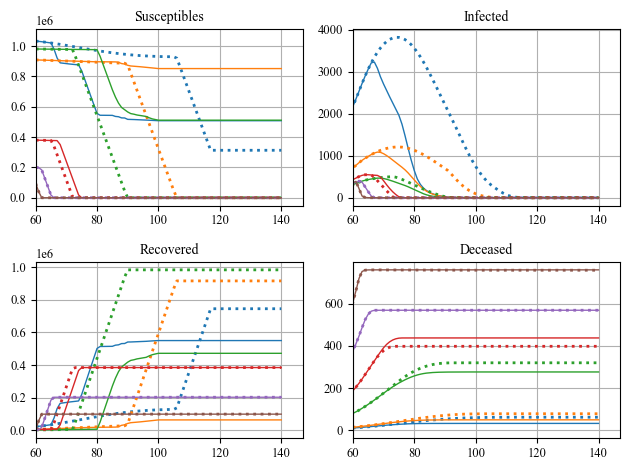

In [9]:
plt.figure()

for i in range(n_states):
    plt.subplot(2, 2, i+1)
    for j in range(n_age):
        plt.plot(x_mpc[i, j], color=colors[j], alpha=1, linewidth=1)
        plt.plot(x_nat[i, j], linestyle=':', color=colors[j], linewidth=2)
        plt.title(patient_group[i])
        plt.grid(True)
        plt.xlim(vac_start)

plt.tight_layout()
plt.savefig('states_comparison.pdf', bbox_inches='tight', dpi=300)

# Input evolution plot

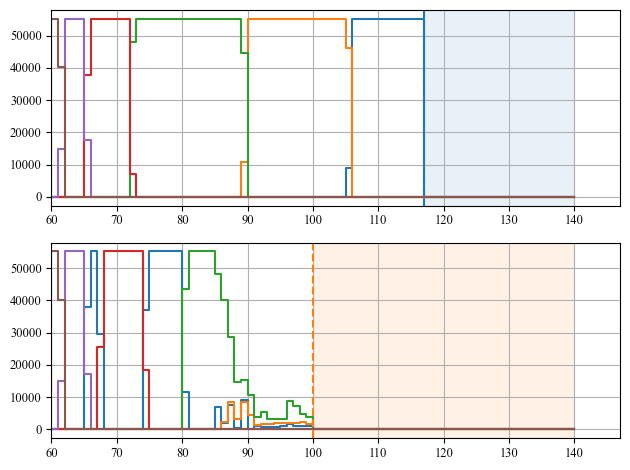

In [10]:
plt.figure()

plt.subplot(2, 1, 1)
for i in range(n_age):
    plt.step(range(sim_time), u_nat[i], where='post', alpha=1, color=colors[i])
plt.axvspan(erad_nat, sim_time-1, color=colors[0], alpha=1e-1)
plt.axvline(erad_nat, linestyle='--', color=colors[0])
plt.grid(True)
plt.xlim(vac_start)

plt.subplot(2, 1, 2)
for i in range(n_age):
    plt.step(range(sim_time), u_mpc[i], where='post', alpha=1, color=colors[i])
plt.axvspan(erad_mpc, sim_time-1, color=colors[1], alpha=1e-1)
plt.axvline(erad_mpc, linestyle='--', color=colors[1])
plt.grid(True)
plt.xlim(vac_start)

plt.tight_layout()
plt.savefig('input_comparison.pdf', bbox_inches='tight', dpi=300)

## Infected evolution plot

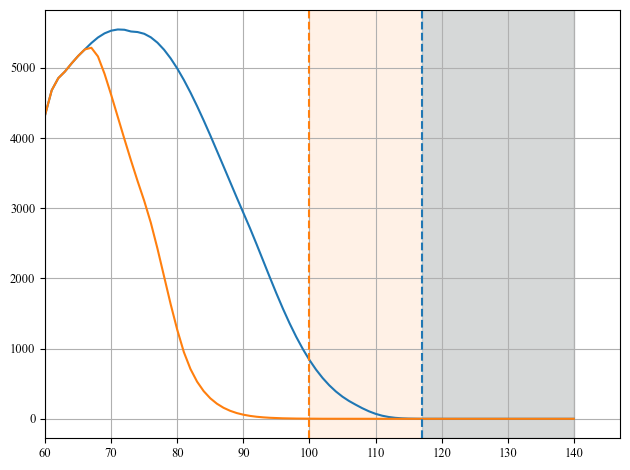

In [11]:
rs_nat = x_nat[1].sum(axis=0)
rs_mpc = x_mpc[1].sum(axis=0)

plt.figure()
plt.plot(rs_nat, color=colors[0])
plt.plot(rs_mpc, color=colors[1])
plt.xlim(vac_start)
plt.axvline(erad_nat, linestyle='--', color=colors[0])
plt.axvline(erad_mpc, linestyle='--', color=colors[1])
plt.axvspan(erad_nat, sim_time-1, color=colors[0], alpha=2e-1)
plt.axvspan(erad_mpc, sim_time-1, color=colors[1], alpha=1e-1)
plt.grid(True)

plt.tight_layout()
plt.savefig('infected_comparison.pdf', bbox_inches='tight', dpi=300)

## Deceased evolution plot

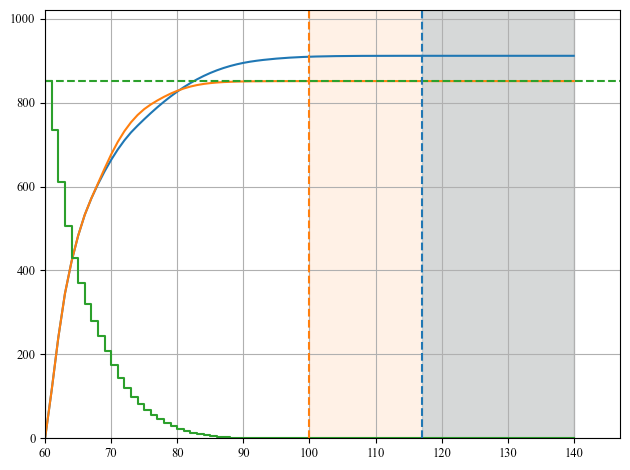

In [12]:
plt.figure()

D_evol_nat = D_nat.sum(axis=0) - D_nat[:, vac_start].sum(axis=0)
D_evol_mpc = D_mpc.sum(axis=0) - D_mpc[:, vac_start].sum(axis=0)

plt.plot(D_evol_nat, color=colors[0])
plt.plot(D_evol_mpc, color=colors[1])
plt.step(range(sim_time), J_mpc, where='post', color=colors[2])
plt.axhline(J_mpc[vac_start], linestyle='--', color=colors[2])
plt.axvline(erad_nat, linestyle='--', color=colors[0])
plt.axvline(erad_mpc, linestyle='--', color=colors[1])
plt.axvspan(erad_nat, sim_time-1, color=colors[0], alpha=2e-1)
plt.axvspan(erad_mpc, sim_time-1, color=colors[1], alpha=1e-1)
plt.xlim(vac_start)
plt.ylim(0)
plt.grid(True)

plt.tight_layout()
plt.savefig('deceased_cost_comparison.pdf', bbox_inches='tight', dpi=300)

# Infected-Deceased evolution plot

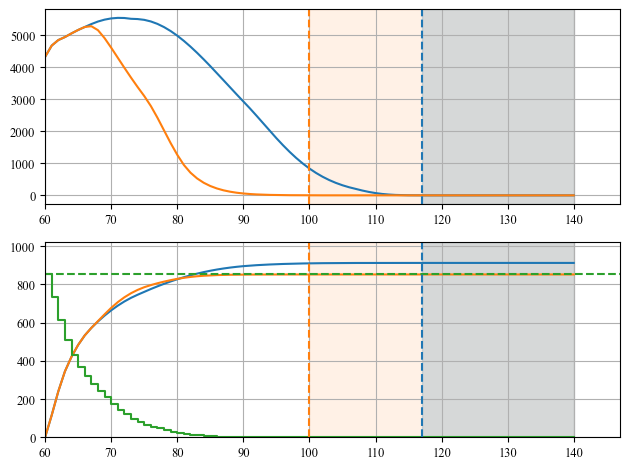

In [13]:
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(rs_nat, color=colors[0])
plt.plot(rs_mpc, color=colors[1])
plt.xlim(vac_start)
plt.axvline(erad_nat, linestyle='--', color=colors[0])
plt.axvline(erad_mpc, linestyle='--', color=colors[1])
plt.axvspan(erad_nat, sim_time-1, color=colors[0], alpha=2e-1)
plt.axvspan(erad_mpc, sim_time-1, color=colors[1], alpha=1e-1)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(D_evol_nat, color=colors[0])
plt.plot(D_evol_mpc, color=colors[1])
plt.step(range(sim_time), J_mpc, where='post', color=colors[2])
plt.axhline(J_mpc[vac_start], linestyle='--', color=colors[2])
plt.axvline(erad_nat, linestyle='--', color=colors[0])
plt.axvline(erad_mpc, linestyle='--', color=colors[1])
plt.axvspan(erad_nat, sim_time-1, color=colors[0], alpha=2e-1)
plt.axvspan(erad_mpc, sim_time-1, color=colors[1], alpha=1e-1)
plt.xlim(vac_start)
plt.ylim(0)
plt.grid(True)

plt.tight_layout()

plt.savefig('combined_comparison.pdf', bbox_inches='tight', dpi=300)